# 0. Introduction

## 0.1 Readings

A good resource for today's task (besides the assigned readings from last week) is the following tutorial: [Word2Vec Tutorial: The SkipGram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). Part 2 provides a really good overview of negative sampling!

## 0.2 Task

This week your tasks will be:
1. Train a CBOW model with a real world dataset, explore how the parameters affect the model.
2. Learn how to evaluate an embedding, through intrinsic and extrinsic evaluation.
3. Build a SkipGram model, based on your experience on CBOW.
4. Extra Credit: implement negative sampling!

## 0.3 Instruction

To follow along this exercise, you want to execute the cells by clicking on them and press *Run* or hit *Shift+Enter*, from top to bottom.


# 1. CBOW


Our first task is to build our very own CBOW. In this section, you will **NOT** be required to write code for the network. Instead, you will be exploring the model by forming hypothesis and testing them through different parameter settings. Although you don't need to write code, you are encouraged to explore the model by writing code to test things out.

First, let's remind ourselves of the famous quote:

> You shall know a word by the company it keeps (Firth, J. R. 1957:11)

What this implies is that it is possible to define a word, or *meaning* of a word in a way that describes a prediction task: **the task of predicting the word given the context**. However, one problem still remains: how to represent the meaning of a word? Luckily, there has already been a line of works that suggest a solution: representing the meaning of a word by a vector -- the vector space model.

Now let's imagine that we are given a near-perfect vector space model that maps meaning of a word to vector. One of the easiest ways to solve the task then, is that we can literally just use the sum of the context vectors as the inputs, the target word vector as the output, and fit it through a linear model!

And that is exactly what CBOW is doing: <img src="figures/cbow.png" alt="cobw" style="width: 400px;"/>

The weights between the input and hidden layer are the vector space model mapping, and the weights between the hidden and output layer are the linear prediction model. 

The only catch is that we don't have that near-perfect vector space model given to us! Thus, our goal is to jointly learn (1) a representation of the word, and (2) a prediction model. In the following sections, we will explore how to do that through PyTorch.



## 1.1 Building our training set

We want to start with building a training set. For the purpose of this exploratory exercise, you will be using a medium size corpus: the [IMDB movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) (you should already downloaded it in `README.md`)


### Data Preprocessing

First, we removed all punctuations and lowercased everything, and tokenize it by whitespace.

In [1]:
# A utility collections for data processing, make sure you already download the data(see README.md)
from utils import read_imdb_data

# read_imdb_data removes punctuations and lowercase everything
X_raw_train, y_train = read_imdb_data('../data/aclImdb/train')
raw_text = ' '.join(X_raw_train).split()

To make sure that it is properly loaded, let's peek into the content a bit:

In [2]:
print(' '.join(raw_text[:30]))

story of a man who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy a formal orchestra audience is


# Filter the Vocab

For the purpose of this assignment, and for the sake of training time, we limit the vocabulary to the most common 1000 words.

In [3]:
from collections import Counter

# pick the top words only
raw_text_count = Counter(raw_text)
vocab = set(list(zip(*raw_text_count.most_common(1000)))[0])
vocab_size = len(vocab)

We then only keep the selected words in the raw text.

In [4]:
# filter raw text by vocab
text = [r for r in raw_text if r in vocab]

---
# Question 1

The preprocessing steps introduced here seem very naive, and potentially problematic. Before you read further down the exercise, based on your understanding of CBOW, 

1. list three potential concerns with the preprocessing choices, explain why they might be a concern.
2. potential fixes for these concerns.
---

### Building the Dataset

Now let's build our dataset! First we define some handy helper functions:

In [5]:
def make_context_vector(context, word_to_ix):
    '''
    helper function to translate context into indexes for inputs
    In:
        context: a list of words
        word_to_ix: a mapping from word to index
    Out:
        idxs: a list of indexes
    '''
    idxs = [word_to_ix[w] for w in context]
    return idxs

In [6]:
def data_batcher(X, Y, batches=5):
    '''
    helper function to batch data, note that batches is not the size of 
    the batch, but how many batches the dataset is divided into.
    In:
        X: a matrix of size (num_sample, CONTEXT_SIZE*2)
        Y: an array of size (num_sample)
        batches: how many batches the dataset is divided into, default:5
    Out:
        a batch of X and Y
    '''
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    for i in range(batches):
        start = int((i * X.shape[0]) / batches)
        end = int(((i + 1) * X.shape[0]) / batches)
        yield X[start:end, :], Y[start:end]

Recall that our given (X) is the context, our target (Y) is the word. 

We then build our dataset by iterating through the filtered text and mapping the words to indexes.

In [7]:
import numpy as np

# Let's set the context window size to 2 for now
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right

# A mapping from word to index
word_to_ix = {word: i for i, word in enumerate(vocab)}

X = []
Y = []
# iterate through the text to build dataset
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    context = [text[i + j] for j in range(-CONTEXT_SIZE, CONTEXT_SIZE+1) if not j==0]
    target = text[i]
    # the data translate to indexes, X is the context, Y is the target word.
    X.append(make_context_vector(context, word_to_ix))
    Y.append(word_to_ix[target])

# convert to numpy for easier data handling later
X = np.array(X, dtype=int)
Y = np.array(Y, dtype=int)

Let's investigate what X and Y are a little bit by peeking into them:

In [8]:
# Let's print the first X, Y pair
x0 = X[0]
y0 = Y[0]
print(x0)
print(y0)

[837 483 824  26]
116


In [9]:
# x0 is the indexes of the context, while y0 is the index of the target word.
print(text[:5])
print([word_to_ix[w] for w in text[:5]])

['story', 'of', 'a', 'man', 'who']
[837, 483, 116, 824, 26]


## 1.2 CBOW with PyTorch

Now that we have our dataset built, let's import PyTorch!

Note: if importing PyTorch failed, first try to click on **Kernel->Change Kernel->Python \[conda env:pytorch_w2v\]** on the upper bar of the notebook. It is likely that you did not set the kernel (which is what the jupyter notebook is running on) to the one you had pytorch installed. If you change the kernel, please re-run this jupyter notebook.

In [10]:
# import PyTorch
import torch
# torch.nn contains modules or subcomponents of the network required to train the network.
import torch.nn as nn
# torch.nn.functional is a collection of handy functions that you can build into the model
import torch.nn.functional as F
# torch.optim contains optimizers to update the parameters of network
import torch.optim as optim

"""
Variable in torch.autograd is used to tell pytorch that 
the object should be put into the PyTorch computation graph. 
See readings for more details.
"""
from torch.autograd import Variable

# Let's also set a fix random seed so you can replicate the result
torch.manual_seed(1234)

Now, let's look at two modules of PyTorch that will be especially useful for our implementation of CBOW: `nn.Embedding` and `nn.Linear`

Note: In PyTorch, if you don’t specify, the `Tensor` created (and thus the parameters in `nn.Embedding` and `nn.Linear`) will be all random.

In [11]:
print(nn.Embedding.__doc__)

A simple lookup table that stores embeddings of a fixed dictionary and size.

    This module is often used to store word embeddings and retrieve them using indices.
    The input to the module is a list of indices, and the output is the corresponding
    word embeddings.

    Args:
        num_embeddings (int): size of the dictionary of embeddings
        embedding_dim (int): the size of each embedding vector
        padding_idx (int, optional): If given, pads the output with zeros whenever it encounters the index.
        max_norm (float, optional): If given, will renormalize the embeddings to always have a norm lesser than this
        norm_type (float, optional): The p of the p-norm to compute for the max_norm option
        scale_grad_by_freq (boolean, optional): if given, this will scale gradients by the frequency of
                                                the words in the mini-batch.
        sparse (boolean, optional): if ``True``, gradient w.r.t. weight matrix will be a

In [12]:
print(nn.Linear.__doc__)

Applies a linear transformation to the incoming data: :math:`y = Ax + b`

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, in\_features)` where `*` means any number of
          additional dimensions
        - Output: :math:`(N, *, out\_features)` where all but the last dimension
          are the same shape as the input.

    Attributes:
        weight: the learnable weights of the module of shape
            (out_features x in_features)
        bias:   the learnable bias of the module of shape (out_features)

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = autograd.Variable(torch.randn(128, 20))
        >>> output = m(input)
        >>> print(output.size())
    


### The CBOW model

Now, it's the exciting part. Let's build our model!

Recall that network structure of CBOW is equivalent to $A\left ( \sum_{w \in Context} q_w \right ) + b$, where $q_w$ is the vector representation of word $w$, A and b are parameters for the linear prediction model. If we applied log softmax to convert the output to log probability, the output of network then becomes: 

$$\log P(w_i|context) = logSoftmax\left (A\left ( \sum_{w \in context} q_w \right ) + b\right )$$

Our goal is then

$$arg\min_{A, b, Q} E_{(context, target) \sim D} \left [-\log P(w_{target}|context)\right ] $$

where $Q$ is the matrix of embeddings, and D is a distribution that context and target words are drawn from.


With this in mind, our model is thus:

In [13]:
class CBOW(nn.Module):
    """
    A PyTorch implementation of CBOW for exploratory purpose.
    
    Args:
        - vocab_size: size of the vocabulary
        - embedding_dim: dimension of the representation vector for words
        - word_to_ix: a mapping from word to index
    
    Shape:
        - Input: LongTensor (N, W), N = mini-batch size, 
                 W = number of indices to extract per mini-batch
        - Output: (N, vocab_size),  N = mini-batch size
    
    """

    # Initializing the model, instantiating the required module (Not linking them)
    def __init__(self, vocab_size, embedding_dim, word_to_ix):
        # A standard python way of saying CBOW is going to inherit nn.Module
        super(CBOW, self).__init__()
        
        self.word_to_ix = word_to_ix
        
        """
        We create an nn.Embedding instance with vocab size and embedding 
        dimension specified. sparse=True enable sparse gradient updates, 
        which speed up the computation and save memory.
        """
        self.emb = nn.Embedding(vocab_size, embedding_dim, sparse=True)
       
        """
        We create an nn.Linear instance with embedding_dim as the input
        features size and vocab_size as the output size. Recall that 
        the goal of nn.Linear is a prediction model which maps from an 
        embedding to scores over the vocabulary space.
        """
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
        """
        We create an nn.LogSoftmax instance that convert output of 
        self.linear to log probility over dim=1. dim here stands for 
        dimension.

        Just like numpy, PyTorch's Tensor is also an n-dimensional array.
        Since the input we will pass in at a time is a batch of data points, 
        the first dimension (dim=0) is the batch dimension (can be 
        understood as a list of data point). Thus, we need to tell LogSoftmax
        that dim=1 is the actual data point.
        """
        self.logsoftmax = nn.LogSoftmax(dim=1)

    # Here is where we acutally link the modules to describe how the data flow through the network.
    def forward(self, inputs):
        """
        - inputs: LongTensor (N, W), N = mini-batch size, 
                  W = number of indices to extract per mini-batch
        - outputs: (N, vocab_size),  N = mini-batch size
        """
        out = self.emb(inputs).sum(dim=1)
        out = self.linear(out)
        return self.logsoftmax(out)

    # helper function to retrieve the trained vector space model (or word embedding)
    def word_embedding(self):
        return self.emb.weight
    
    # helper function to do a word to vector lookup
    def word2vec(self, word):
        return self.emb.weight[self.word_to_ix[word], :]

Note that there really wasn't many lines of code! Most of those are acutally my comments!


### Training

Next we need to actually train the model.

In [14]:
# handy library to help you visualize the progress
import progressbar

def train_cbow(model, num_epochs=5, batches=100):
    """
    A function to call for training given the model.

    Parameters for train_cbow():
        - model: a CBOW instance
        - num_epochs: number of time the entire dataset is trained through
        - batches:  recall that batches is not the size of the batch, 
                    but how many batches the dataset is divided into.
    """ 

    
    """
    The negative log likelihood loss. 
    It is useful to train a classification problem with C classes.
    Expected to contain log-probabilities of each class. 
    See nn.NLLLoss.__doc__ for more details.
    """
    criterion = nn.NLLLoss()
    
    """
    The stochastic gradient descent optimizer used to update weights, 
    once gradient is computed. We set a learning rate of 0.001, and 
    momentum of 0.9.
    """
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # keep track of the loss of the model to see if the model converges.
    losses = []
    
    for epoch in range(num_epochs):
        
        # progressbar setting
        widgets = ['Epoch {} '.format(epoch), progressbar.Percentage(), ' ', progressbar.Bar(), ' ', progressbar.ETA()]
        bar = progressbar.ProgressBar(widgets=widgets, max_value=batches)

        # bar(data_batcher(X, Y, batches)) is a way for progressbar to keep track of data_batcher(X, Y, batches)
        for context, target in bar(data_batcher(X, Y, batches)):
            
            """
            Wrap our training pair context and target first through torch.LongTensor, 
            and then through Variable.
            
            torch.LongTensor is a holder for integer variable, and is expected by the model as input.
            
            Variable is used to put x and y into the PyTorch computation graph. See readings for more details.
            """
            x = Variable(torch.LongTensor(context))
            y = Variable(torch.LongTensor(target))
            
            """
            zero the parameter gradients
        
            If you don't do so, the gradients will accumulate and lead to significant slow down.
            """
            optimizer.zero_grad()

            """
            forward
            
            The final piece how connecting the network to the data! 
            We feed the data in, and get a loss value back.
            """
            # run this input x forward through the network to get your output vector
            outputs = model(x)
            # compare outputs against correct output y and generate loss using the loss function
            loss = criterion(outputs, y)
            
            """
            backward
            
            This may seem like black magic, but what it really does is 
            essentially doing chain rule (or a fancier term -- backpropagation)
            
            Intuitively, for every object x that is a Variable, this calculates
            
            d loss
            -------
            d x
            
            And exactly how to break down the above term to get the actual gradient?
            This is done automatically by the computation graph PyTorch build while 
            you write the model! Thus the name 'autograd'.
            """
            loss.backward()
            
            """
            optimize
            
            Now that for every Variable, we have calculate the gradient, we can use an
            optimizer to update the weights!
            
            SGD for example, does something intuitively like this:
            w = w + learning_rate*w.grad
            """
            optimizer.step()
            
            # just to record the loss
            losses.append(loss.data.numpy())
    return losses

Let's start training!

In [15]:
# import matplotlib to plot the losses
from matplotlib import pyplot as plt

We first initalize a CBOW model of vocab_size 1000 (the top 1000 words we limited it to) and train a vector space model with embbeding dimension=10, for the sake of shortening the training time. Note that a dimension=10 may not be optimal, and will be a parameter that you can potentially tune in Question 2.

We then train the model for 3 epoches, with 100,000 data batches. These are also parameters that you can potentially tune.

This [link](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network) provides a nice discussion between data batches and iterations. [Here](https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks) is a discussion for the definition of epoch, iteration, and data batch.

Epoch 0 100% |##################################################| Time: 0:03:17
Epoch 1 100% |##################################################| Time: 0:03:16
Epoch 2 100% |##################################################| Time: 0:03:24


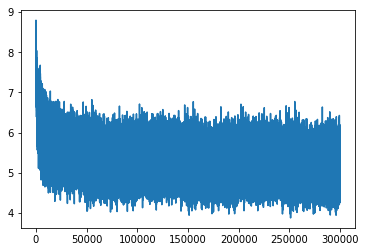

In [16]:
model = CBOW(vocab_size=vocab_size, embedding_dim=10, word_to_ix=word_to_ix)

# Train with 3 epochs, 100,000 data batches
plt.plot(train_cbow(model, num_epochs=3, batches=100000))

# 2. Evaluation

Now that we have a model trained, how do we know if it is good at all? There are generally two ways of evaluating a vector space model: intrinsic and extrinsic evaluation.


## 2.1 Intrinsic Evaluation

### Sanity Check

**Sanity check**, or **smell test**, is a quick and dirty way to check if a model is doing anything reasonable at all. The idea of a sanity check is to check for a property that a good model should certainly hold. In our case, since we are training on a movie review dataset, we can safely assume that *'movie'* and *'film'* should have similar representation in a reasonably well-trained model, as they should appear in similar context.

In [17]:
# this is PyTorch's cosine similarity module
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

# The word 'movie' and 'film' should appear in similar context, and thus should have similar representation.
cos(model.word2vec('movie'), model.word2vec('film'))

Variable containing:
 0.9103
[torch.FloatTensor of size 1]

Let's also check the 10 closest words to *movie*

In [18]:
def closest_n_words(model, vocab, word, n=10):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    word_vec = model.word2vec(word)
    scores=[]
    for v in vocab:
        if not v == word:
            score = cos(model.word2vec(v), word_vec)
            scores.append((score, v))
    
    """
    return the n closest words to the target word

    The purpose of using score[0].data.numpy() is to convert Tensor into
    numpy array, since there are many things you cannot easily do to a
    Tensor (like comparing two value and return a boolean, since it is 
    not differentiable!)
    """
    n_closest = list(zip(*(sorted(scores, key=lambda score: score[0].data.numpy(), reverse=True)[:n])))[1]
    return n_closest

In [19]:
closest_n_words(model, vocab, 'movie')

('film',
 'alone',
 'up',
 'important',
 'anything',
 'monster',
 'drama',
 'police',
 'however',
 'words')

### Word Similarity Dataset

The intuition that a good vector space model should rank words that are similar closer to the top, and words that are dissimilar closer to the bottom, is what is behind word similarity test.

A data point in a word similarity dataset often consists of 2 words and a score of how related those 2 words are, according to human judgement.

Here's a peek into [WS353](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/) dataset:

In [20]:
import pandas as pd
df_ws353sim = pd.read_csv('../data/en/EN-WS-353-SIM.txt', sep='\t', header=None, names=['word1', 'word2', 'ws_score'])
df_ws353sim.head(15)

,word1,word2,ws_score
0,tiger,cat,7.35
1,tiger,tiger,10.00
2,plane,car,5.77
3,train,car,6.31
4,television,radio,6.77
5,media,radio,7.42
6,bread,butter,6.19
7,cucumber,potato,5.92
8,doctor,nurse,7.00
9,professor,doctor,6.62


Now, you can also generate cosine similarity scores for all these word pairs (if available) using our model.

In [21]:
def cosine_similarity(row, model, vocab, cos):
    word1 = row['word1'].lower()
    word2 = row['word2'].lower()
    if word1 in vocab and word2 in vocab:
        return cos(model.word2vec(word1), model.word2vec(word2)).data.numpy()[0]
    else:
        return np.nan

df_ws353sim['cbow_score'] = df_ws353sim.apply(lambda row: cosine_similarity(row, model, vocab, cos), axis=1)
df_ws353sim.head(10)

,word1,word2,ws_score,cbow_score
0,tiger,cat,7.35,NaN
1,tiger,tiger,10.00,NaN
2,plane,car,5.77,NaN
3,train,car,6.31,NaN
4,television,radio,6.77,NaN
5,media,radio,7.42,NaN
6,bread,butter,6.19,NaN
7,cucumber,potato,5.92,NaN
8,doctor,nurse,7.00,NaN
9,professor,doctor,6.62,NaN


Since we have a relatively small vocab size, many of the words will be missing, let's drop these row for now.

In [22]:
df_ws353sim_dropna = df_ws353sim.dropna().copy()
df_ws353sim_dropna.head(10)

,word1,word2,ws_score,cbow_score
64,Japanese,American,6.50,0.114776
70,life,death,7.88,-0.062488
72,type,kind,8.97,0.281635
73,street,place,6.44,-0.129557
90,man,woman,8.30,-0.759632
103,street,children,4.94,0.193394
125,start,year,4.06,0.228381
128,theater,history,3.91,-0.269554
144,experience,music,3.47,0.097135


Intuitively, a good model would generate a similar scores compared to that of humans.

However, it is relatively hard to compare 2 variable with different range. A common approach then, is to transform the scores into rank before comparing them.

In [23]:
df_ws353sim_dropna['ws_rank'] = df_ws353sim_dropna['ws_score'].rank(ascending=False).astype(int)
df_ws353sim_dropna['cbow_rank'] = df_ws353sim_dropna['cbow_score'].rank(ascending=False).astype(int)
df_ws353sim_dropna.head(10)

,word1,word2,ws_score,cbow_score,ws_rank,cbow_rank
64,Japanese,American,6.50,0.114776,4,4
70,life,death,7.88,-0.062488,3,6
72,type,kind,8.97,0.281635,1,1
73,street,place,6.44,-0.129557,5,7
90,man,woman,8.30,-0.759632,2,9
103,street,children,4.94,0.193394,6,3
125,start,year,4.06,0.228381,7,2
128,theater,history,3.91,-0.269554,8,8
144,experience,music,3.47,0.097135,9,5


But exactly how do we measure how *close* two rankings are? The answer is that we want to calculate the [Spearman's rho correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), which is measuring the rank correlation of 2 variables.

In [24]:
from scipy import stats
"""
calculating spearman's rho using scipy.stats
Spearman's rho range from [-1, 1]
we *100 to scale it to [-100, 100]
"""
stats.stats.spearmanr(df_ws353sim_dropna['ws_rank'], df_ws353sim_dropna['cbow_rank'])[0]*100

6.666666666666667

By repeating this process for all the other datasets located in `data/en/`, you can get a fairly overall feel of how the model is doing compared to human judgements.

For you convenience, here I have provided a class (Wordsim) that automatically test an array of word similarity datasets, taken (modified to work on Python 3 and PyTorch) from Kazuya Kawakami's [embedding-evaluation](https://github.com/k-kawakami/embedding-evaluation) code.

What these datasets are and their properties are also described in the link above.

In [25]:
from utils import Wordsim

wordsim = Wordsim()
"""
convert model to a dictionary of word to numpy array, 
the model must have a model.word_to_ix variable
"""
word2vec = wordsim.convert_to_w2v(model)
word2vec['movie']

array([-0.55316603,  0.50568599,  0.15468752, -0.32579049,  2.10974979,
       -0.56246012, -0.84836906, -2.8567605 ,  0.05953474,  1.67701232], dtype=float32)

In [26]:
result = wordsim.evaluate(word2vec)
wordsim.pprint(result)  # scores reported here are Spearman's rho * 100

+----------------+-------+-----------+----------------+
| Dataset        | Found | Not Found |  Score (rho)   |
+----------------+-------+-----------+----------------+
| EN-MC-30       |   0   |     30    |      nan       |
| EN-MEN-TR-3k   |  132  |    2868   | -4.68663005455 |
| EN-MTurk-287   |   6   |    281    | -65.7142857143 |
| EN-MTurk-771   |   27  |    744    | -13.5531135531 |
| EN-RG-65       |   0   |     65    |      nan       |
| EN-RW-STANFORD |   3   |    2031   |     -50.0      |
| EN-WS-353-ALL  |   18  |    335    | 18.0598555212  |
| EN-WS-353-REL  |   13  |    239    | 42.8571428571  |
| EN-WS-353-SIM  |   9   |    194    | 6.66666666667  |
| EN-YP-130      |   0   |    130    |      nan       |
+----------------+-------+-----------+----------------+


## 2.1 Extrinsic Evaluation

While a high score on intrinsic evaluation reflects that we captured important linguistic information, sometime what we really want is to do well on a downstream task.

For the purpose of this assignment, let's assume that we want to evaluate it with the IMDB dataset! (A binary document classification task)

In [27]:
# read in the train and test data
X_raw_train, y_train = read_imdb_data('../data/aclImdb/train')
X_raw_test, y_test = read_imdb_data('../data/aclImdb/test')

In [28]:
X_raw_train[0]

'story of a man who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy a formal orchestra audience is turned into an insane violent mob by the crazy chantings of its singers unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting even those from the era should be turned off the cryptic dialogue would make shakespeare seem easy to a third grader on a technical level its better than you might think with some good cinematography by future great vilmos zsigmond future stars sally kirkland and frederic forrest can be seen briefly'

In [29]:
y_train[0]

0

Since our goal is to transform the document into a dense representation vector related to the embedding matrix. One of the easiest way to do that is just by averaging all the word vectors in the document. 


To efficently do that, let's start by converting the document to an normalized bag-of-words style vector, using `CountVectorizer` and `normalize` in `sklearn`

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
# vocabulary=word_to_ix ensure that we have the exact same set of vocab and index mapping.
vectorizer = CountVectorizer(vocabulary=word_to_ix)

In [31]:
# tranform train and test to bag-of-words style
X_train_bow = vectorizer.transform(X_raw_train)
X_test_bow = vectorizer.transform(X_raw_test)

# let's also l1-normalize the bag-of-word vectors by count
from sklearn.preprocessing import normalize
X_train_norm = normalize(X_train_bow, axis=1, norm='l1')
X_test_norm = normalize(X_test_bow, axis=1, norm='l1')

/Users/sidshing/anaconda2/envs/pytorch-rg/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [32]:
# extract the embedding_matrix, turn in into numpy matrix
embedding_matrix = model.word_embedding().data.numpy()

For the next step, we need to transform the normalized bag-of-words vector by the embedding matrix. We can easily do that by:

$$X_{emb} = X_{bow} \Phi$$

where $X_{emb}$ is the dense representation of documents, $X_{bow}$ is the normalized bag-of-words representation of documents, and $\Phi$ is the embedding matrix.

In [33]:
X_train = np.matmul(X_train_norm.todense(), embedding_matrix)
X_test = np.matmul(X_test_norm.todense(), embedding_matrix)

Let's use Logistic Regression as our learner.

In [34]:
from sklearn import linear_model
clf = linear_model.LogisticRegression()

In [35]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
clf.score(X_test, y_test)

0.58316000000000001

---
# Question 2

Now that you have learned how to evaluate a vector space model, let's explore the model by changing the parameters!

For purposes of this question, "changing the parameters" can be interpreted broadly: it can include numeric parameters of the model (e.g. the number of dimensions in your embedding), parameters related to the training (e.g. batch size, number of training epochs), and even choices about preprocessing (e.g. decisions that were made about normalization, filtering out of vocabulary, etc.).

Form **two hypotheses** about parameter choices and how they are affecting the modeling. For each hypothesis, do some experimentations to explore whether your hypothesis is true or not. In your writeup, for each one explain the hypothesis (and its rationale or the intuitions behind it), your experiments, and any results you obtained. There is no need to include code in your writeup.

Note that you may not be able to successfully test a hypothesis, either due to long training time or lack of training data. If that happens, instead of experiments and results, talk about what you tried, give an explanation of why it didn't work, and describe what you would have expected to see if the experiment had run successfully.  What's important is showing that you've grounded your answer to this question in a clear understanding of the material; for example, there should be a clear logic to why an experiment you propose would support or refute your hypothesis, even if you don't get to run the experiment.

Also note that we are not looking for state of the art performance, in terms of the quality of embeddings (you don't even have to beat the current performance, which is a very low bar). The central goal is for you get hands on and get a feel for how this model behaves using some real data.
That said, you are welcome to go beyond what we've provided here, e.g. you could get a model working on a small dataset, and then run it on some larger dataset that is of interest to you. 

---

# 3. SkipGram

The third task is to write codes to train a SkipGram model. Take inspiration from the CBOW classifier trained previously, but remember the implementational differences in SkipGram.

SkipGram, in contrast to CBOW, is trying to predict the context word given the target word:

<img src="figures/skipgram.png" alt="skipgram" style="width: 400px;"/>

Here is a nice tutorial for SkipGram: [Word2Vec Tutorial: The SkipGram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)


Another crucial difference is how you process the data, note that you don't just flip the X and Y. Take the sentence `"was the best of time"` for example, for CBOW, this create 1 training pair:

`(X: ['was', 'the', 'of', 'time'], Y: 'best')`

But for SkipGram, this would actually create 4 training pairs:

1. `(X: ['best'], Y: 'was')`
2. `(X: ['best'], Y: 'the')`
3. `(X: ['best'], Y: 'of')`
4. `(X: ['best'], Y: 'time')`

That is, you split the context vector (what you are trying to predict for SkipGram) into single words. Obviously, these training data pairs have to be translate into indexes before training.

In [ ]:
# You'll need to write code that takes in the dataset and creates 
# the training examples from it.

# Let's set the context window size to 2 for now
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right

X = []
Y = []
# iterate through the text to build dataset
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    context = [text[i + j] for j in range(-CONTEXT_SIZE, CONTEXT_SIZE+1) if not j==0]
    target = text[i]
    # the data translate to indexes, X is the context, Y is the target word.
    for word in context:
        """
        TODO
        
        Fill in this part of the code for creating the dataset. 
        Remember to use word_to_ix (define in the preprocessing of CBOW)
        to transform word to index.
        
        The shape of X and Y (and also how you process them here) depend
        on your implementation of SkipGram, as X and Y would be fed into 
        the SkipGram model in batches.
        """
        pass

# convert to numpy for easier data handling later
X = np.array(X, dtype=int)
Y = np.array(Y, dtype=int)

Now let's get to actually building the SkipGram model. For the purpose of this assignment, you do **NOT** need to implement negative sampling or hierarchical softmax. Actually, implementing negative sampling will be the extra credit. All you need to do is follow the same log softmax approach to get a probability distribution.

Some hints: notice that CBOW and SkipGram have very similar structures. Also, depending on how you built your dataset, your network may or may not need to change. You might also need to rewrite `data_batcher` to fit your need.

In [ ]:
class SkipGram(nn.Module):
    """
    A PyTorch implementation of SkipGram for exploratory purpose.
    
    Args:
        - vocab_size: size of the vocabulary
        - embedding_dim: dimension of the representation vector for words
        - word_to_ix: a mapping from word to index
    
    Shape:
        - Input: Depends on your dataset
        - Output: (N, vocab_size),  N = mini-batch size
    
    """

    # Initializing the model, instantiating the required module (Not linking them)
    def __init__(self, vocab_size, embedding_dim, word_to_ix):
        # A standard python way of saying SkipGram is going to inherit nn.Module
        super(SkipGram, self).__init__()
        
        self.word_to_ix = word_to_ix
        
        """
        TODO
        
        Just like CBOW, you may want to use nn.Embedding, nn.Linear, and/or nn.LogSoftmax
        """
        
        self.emb = None
       

    # Here is where we acutally link the modules to describe how the data flow through the network.
    def forward(self, inputs):
        """
        - inputs: Depends on your dataset
        - outputs: (N, vocab_size),  N = mini-batch size
        """
        pass

    # helper function to retrieve the trained vector space model (or word embedding)
    def word_embedding(self):
        return self.emb.weight
    
    # helper function to do a word to vector lookup
    def word2vec(self, word):
        return self.emb.weight[self.word_to_ix[word], :]

Once you've created the model, you'll need to train it. Here is a skeleton:

In [ ]:
def train_skipgram(model, num_epochs=5, batches=100):
    """
    A function to call for training given the model.

    Parameters for train_skipgram():
        - model: a SkipGram instance
        - num_epochs: number of time the entire dataset is trained through
        - batches:  recall that batches is not the size of the batch, 
                    but how many batches the dataset is divided into.
    """ 

    
    """
    TODO
    
    choose a loss function
    """
    criterion = None
    
    """
    TODO
    
    choose a optimizer
    """
    optimizer = None

    # keep track of the loss of the model to see if the model converges.
    losses = []
    
    for epoch in range(num_epochs):
        
        # progressbar setting
        widgets = ['Epoch {} '.format(epoch), progressbar.Percentage(), ' ', progressbar.Bar(), ' ', progressbar.ETA()]
        bar = progressbar.ProgressBar(widgets=widgets, max_value=batches)

        # bar(data_batcher(X, Y, batches)) is a way for progressbar to keep track of data_batcher(X, Y, batches)
        # data_batcher might need to be rewrited, depending out how you build your dataset.
        for target, context in bar(data_batcher(X, Y, batches)):
            
            """
            TODO
            
            Remember to wrap you x and y with Variable
            """
            x = None
            y = None
            
            
            """
            zero the parameter gradients
            If you don't do so, the gradients will accumulate and lead to significant slow down.
            """
            optimizer.zero_grad()

            """
            TODO
            
            Feed the data in, and get a loss value back.
            """
            # run this input x forward through the network to get your output vector
            outputs = None
            # compare outputs against correct output y and generate loss using the loss function
            loss = None
            
            """
            Optional TODO: modify this part if needed
            
            backward
            """
            loss.backward()
            
            """
            Optional TODO: modify this part if needed
            
            optimize
            """
            optimizer.step()
            
            # just to record the loss
            losses.append(loss.data.numpy())
    return losses

Now let's train your model! (Feel free to change this piece of code to fit your need)

In [ ]:
model = SkipGram(vocab_size=vocab_size, embedding_dim=10, word_to_ix=word_to_ix)

# Train with 3 epochs, 100,000 data batches
plt.plot(train_skipgram(model, num_epochs=3, batches=100000))

Remember to evaluate it! Here is a piece of code for the smell test. You are free to evaluate it with any other method.

In [ ]:
# this is PyTorch's cosine similarity module
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

# The word 'movie' and 'film' should appear in similar context, and thus should have similar representation.
cos(model.word2vec('movie'), model.word2vec('film'))

---

# Question 3

Now that you have implemented SkipGram, please describe to us how you did it!

Do **NOT** just paste all your code inside the writeup, write down your logic for why you choose to design the specific component the way it is. The documentation we wrote with CBOW might be a good reference. Although we discourage you to paste all your code, but if snippet (a few lines) of code helps with the explanation, feel free to include it!

You need to at least describe your code in 4 parts:

1. How you build the dataset
2. Implementation of SkipGram module
3. Implementation of train_skipgram()
4. The choice of your SkipGram parameters, and why

Other discussions are definitely welcome! 

---

---

# Question 4

Finally, evaluate your SkipGram model with the sanity check plus another method. Describe the evaluation method as well as the result. Again, we are not looking for any state of the art here, but you should at least pass the sanity check. 

---

# Extra Credit: Negative Sampling (20%)

Finally, for those of you who want to take on the challenge, I encourage you to attempt to implement negative sampling! Recall the negative sampling loss is defined as:

$$\log \sigma \left ( {q^{\prime}_{w_O}}^\top q_{w_I} \right ) + \sum^{k}_{i=1} E_{w_i \sim P_n \left ( w \right )}\left [ \log \sigma \left ( -{q^{\prime}_{w_i}}^\top q_{w_I} \right ) \right ]$$

in the word2vec [reading](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). $q^\prime$ refers to the output embedding, whereas $q$ referes to the input embedding. See reading for more details

Your two options are to write a general purpose negative sampling loss module, or to wrap the whole thing up into the implementation of SkipGram. 

Hint: the loss function of PyTorch is really just another `nn.Module` that returns a scalar (more accurately, a batch of scalars). You might also want to consider using 2 `nn.Embedding` modules, as you no longer need to perform softmax over the vocabulary space.

In [ ]:
class NegativeSamplingSkipgram(nn.Module):
    """
    Your code goes here. 
    You are free to implement it any way you want
    """
    pass

In [ ]:
NUM_EPOCHS = 5

# Your code goes here.
# Remember to instantiate a model, loss function, and optimizer

for i in range(NUM_EPOCHS):
    # Your code goes here.
    # You may use the data_batcher function, but remember to wrap your batches
    # in a Variable()
    pass

---

# Question Extra Credit

Describe what you did with `NegativeSamplingSkipgram` just like Question 3. You only need to be brief and describe the core concept.

---